# Code used in Ch. 12: Productionizing ML

* I didn't present any results from simulations in the Chapter
* But I include here two simulations for model and data drift as backup material

In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import cycler
from sklearn.linear_model import LinearRegression
from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# set plotting parameters from the beginning
font = {'family' : 'monospace',
        'weight' : 'normal',
        'size'   : 14}
axes = {'titlesize' : 22,
        'labelsize' : 20,
       'prop_cycle' : cycler.cycler(color='k')}
lines = {'color' : 'k'}
figure = {'figsize' : (10,4),
         'autolayout' : True,}
matplotlib.rc('font', **font)
matplotlib.rc('axes', **axes)
matplotlib.rc('figure', **figure)
matplotlib.rc('lines', **lines)


# 1. Simulate data drift

* DGP remains constant
* Distribution of features changes in time

In [109]:
def simulate_model(nobs, alpha, dist_dict, seed):
    "Simulate a simple model: y = a0 + b*trend + noise"
    np.random.seed(seed)
    # X ~ Gamma(shape, scale)
    shape = dist_dict['shape']
    scale = dist_dict['scale']
    x = np.random.gamma(shape, scale, size=nobs)
    noise = np.random.randn(nobs)
    y = alpha[0] + alpha[1]*x + noise
    # get nice dataframes
    ydf = pd.DataFrame(y, columns = ['y'])
    xdf = pd.DataFrame(x, columns = ['x'])
    return ydf, xdf

Text(0.5, 1.0, 'Scatter for Independent y,x')

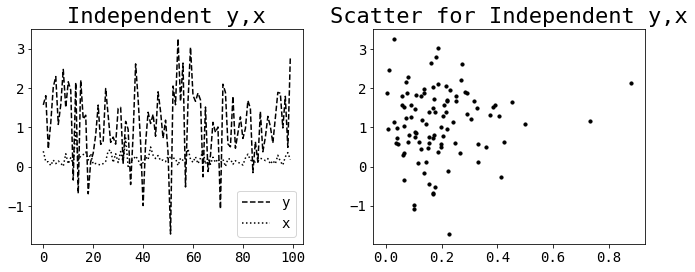

In [110]:
# test
seed = 95610
nobs = 100
alpha = [1,0]
dist_dict = dict()
dist_dict['shape'] = 2
dist_dict['scale'] = 0.1
yt, xt = simulate_model(nobs, alpha, dist_dict, seed)
fig, ax = plt.subplots(1,2)
yt.plot(ax=ax[0], ls = '--')
xt.plot(ax=ax[0], ls = 'dotted')
ax[1].scatter(xt, yt, s=10)
ax[0].set_title('Independent y,x')
ax[1].set_title('Scatter for Independent y,x')

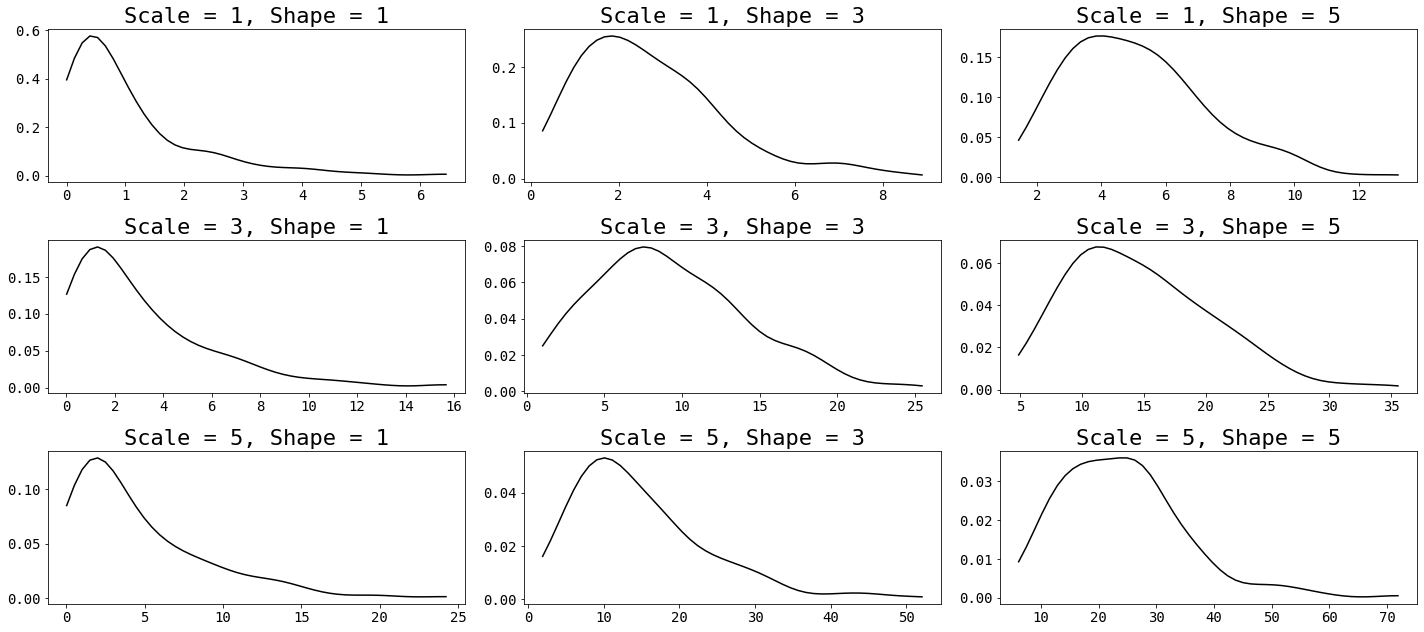

In [116]:
# let's get an idea of what I want to do
scale_arr = [1,3,5]
shape_arr = [1,3,5]
ncols = len(scale_arr)
nrows = len(shape_arr)
fig, ax = plt.subplots(nrows, ncols, figsize = (20,3*nrows))
nobs = 200
for s, scl in enumerate(scale_arr):
    for p, shp in enumerate(shape_arr):
        ax_sp = ax[s,p]
        x_sp = np.random.gamma(shape=shp, scale=scl, size=nobs)
        density = gaussian_kde(x_sp)
        gridx = np.linspace(np.min(x_sp),np.max(x_sp),50).flatten()
        y_kde = density(gridx)
        ax_sp.plot(gridx, y_kde)
        ax_sp.set_title(f'Scale = {scl}, Shape = {shp}')

In [119]:
def simulate_data_drift(nobs, alpha, time_dict, seed):
    "Simulate data drift using a dictionary with time parameters"
    for t, dict_t in time_dict.items():
        y_t, x_t = simulate_model(nobs, alpha, dist_dict = dict_t, seed=seed)
        y_t['regime'] = t
        x_t['regime'] = t
        if t==0:
            ydf = y_t
            xdf = x_t
        else:
            ydf = pd.concat((ydf, y_t),axis=0)
            xdf = pd.concat((xdf, x_t),axis=0) 
            
    return ydf, xdf

Text(0.5, 1.0, 'Mean X for Different Scale Parameters')

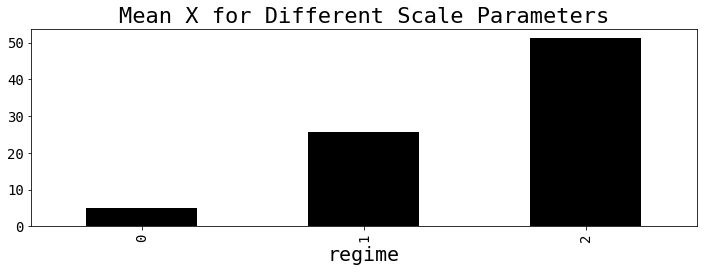

In [127]:
time_dict = dict()
time_dict[0] = {'shape':5, 'scale':1}
time_dict[1] = {'shape':5, 'scale':5}
time_dict[2] = {'shape':5, 'scale':10}

ydf, xdf = simulate_data_drift(nobs, alpha, time_dict, seed)
fig, ax = plt.subplots()
xdf.x.groupby(xdf.regime).mean().plot(kind='bar', ax = ax)
ax.set_title('Mean X for Different Scale Parameters')

[Text(0, 0, 'No Drift'), Text(0, 0, 'Scale = 5'), Text(0, 0, 'Scale = 10')]

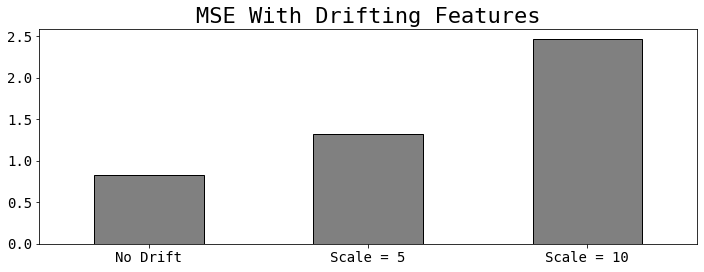

In [164]:
# I want to train with first regime, and evaluate performance on second and third regimes
mse_df = pd.DataFrame(index = range(3), columns = ['regime', 'mse'])
for r in range(3):
    y_r, x_r = ydf.y.loc[ydf.regime==r].values, xdf[['x']].loc[ydf.regime==r]
    x_test = x_r
    y_test = y_r
    if r==0: # split and train
        x_train, x_test, y_train, y_test = train_test_split(x_r, y_r, random_state=15)
        reg_r = LinearRegression().fit(x_train, y_train)
    # calculate mse
    yhat = reg_r.predict(x_test)
    mse = mean_squared_error(y_test, yhat)
    mse_df.loc[r] = [r,mse]

fig, ax = plt.subplots()
mse_df.mse.plot(kind='bar', ax=ax, color='0.5', edgecolor='k')
ax.set_title('MSE With Drifting Features')
scale1 = time_dict[1]['scale']
scale2 = time_dict[2]['scale']
ax.set_xticklabels(['No Drift', f'Scale = {scale1}', f'Scale = {scale2}'], rotation = 0)

# Model drift:
* Same distribution
* Change in DGP parameters

In [191]:
def simulate_model_drift(nobs, df_alpha, dist_dict, seed):
    "Simulate data drift using a dictionary with time parameters"
    for t in df_alpha.index:
        alpha_t = df_alpha.loc[df_alpha.index==t].values.flatten()
        y_t, x_t = simulate_model(nobs, alpha=alpha_t, dist_dict = dist_dict, seed=seed)
        y_t['regime'] = t
        x_t['regime'] = t
        if t==0:
            ydf = y_t
            xdf = x_t
        else:
            ydf = pd.concat((ydf, y_t),axis=0)
            xdf = pd.concat((xdf, x_t),axis=0) 
            
    return ydf, xdf

Text(0.5, 1.0, 'Mean X for Different Slopes')

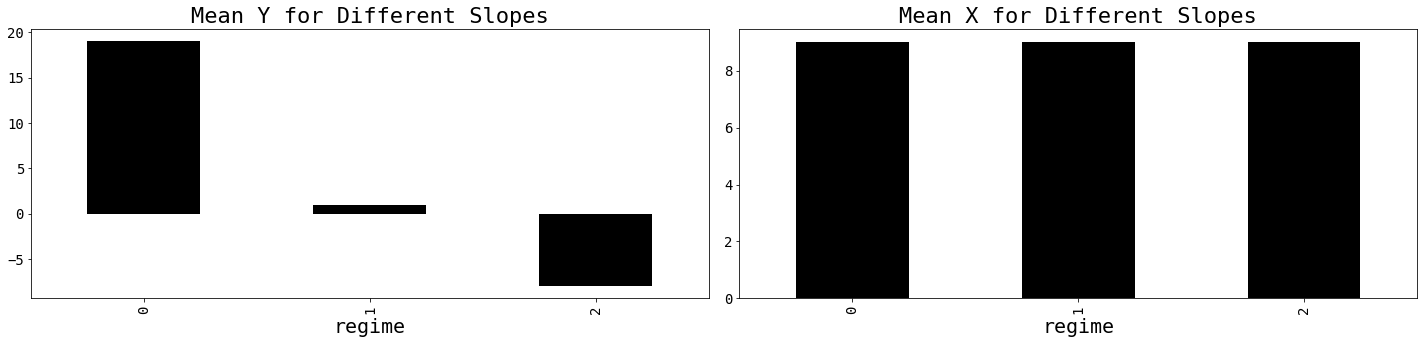

In [200]:
alpha_arr = [[1,2],[1,0],[1,-1]]
df_alpha = pd.DataFrame(alpha_arr, columns = ['a0', 'a1'])
dist_dict = {'shape':3, 'scale':3}
seed = 67331
ydf, xdf = simulate_model_drift(nobs, df_alpha, dist_dict, seed)
fig, ax = plt.subplots(1,2, figsize = (20,5))
# ydf
ydf.y.groupby(xdf.regime).mean().plot(kind='bar', ax = ax[0])
ax[0].set_title('Mean Y for Different Slopes')
# X shouldn't change
xdf.x.groupby(xdf.regime).mean().plot(kind='bar', ax = ax[1])
ax[1].set_title('Mean X for Different Slopes')

  regime       mse
0      0  0.905621
1      1   432.237
2      2   971.098


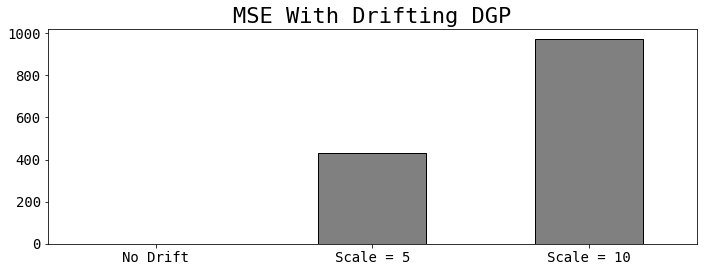

In [201]:
# I want to train with first regime, and evaluate performance on second and third regimes
mse_df = pd.DataFrame(index = range(3), columns = ['regime', 'mse'])
for r in range(3):
    y_r, x_r = ydf.y.loc[ydf.regime==r].values, xdf[['x']].loc[ydf.regime==r]
    x_test = x_r
    y_test = y_r
    if r==0: # split and train
        x_train, x_test, y_train, y_test = train_test_split(x_r, y_r, random_state=15)
        reg_r = LinearRegression().fit(x_train, y_train)
    # calculate mse
    yhat = reg_r.predict(x_test)
    mse = mean_squared_error(y_test, yhat)
    mse_df.loc[r] = [r,mse]

fig, ax = plt.subplots()
mse_df.mse.plot(kind='bar', ax=ax, color='0.5', edgecolor='k')
ax.set_title('MSE With Drifting DGP')
scale1 = time_dict[1]['scale']
scale2 = time_dict[2]['scale']
ax.set_xticklabels(['No Drift', f'Scale = {scale1}', f'Scale = {scale2}'], rotation = 0)
print(mse_df)